In [1]:
#!/usr/bin/env python3

################################
# Scientific imports
###
%matplotlib inline
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astroquery.mast import Observations
from astroquery.mast import Catalogs

###
# General imports
###
import csv, math, io, os, os.path, sys, random, time, bisect
import pandas as pd
import seaborn as sb
import sklearn
from sklearn import metrics
from IPython.display import display

###
# Time imports
###
from tqdm.notebook import tqdm, trange

###
# MatPlotLib Settings
###

plt.rcParams["figure.figsize"] = (20,9)
sb.set()

###
# Global Variables
###
# Lists
fitsList=[]
starlist=[]
planetlist=[]
eblist=[]
beblist=[]
dataframe = pd.DataFrame(columns=['id', 'vals', 'isplanet'])
#idlist=[]
#fluxlist=[]
#isplanetlist=[]

# List Holder
alllists = {}

# Keep track of current LC and it's TIC identifier
lastRandom={
    "number": 0,
    "id": 0
}

################################
# Functions
###
# Function for Reading which LC datafiles we have into a list
def MakingAList(prnt=False):
    fl = []
    fitsroot = "SIM_DATA/"
    fits_directories = [x[0] for x in os.walk('./SIM_DATA/.', topdown=True)]

    for fitsroot, fits_dirs, fits_files in os.walk(fitsroot):
        for fits_file in fits_files:
            fullpath = os.path.join(fitsroot, fits_file)
            if (os.path.splitext(fullpath.lower())[1]).endswith('.fits'):
                fl.append(fullpath)
    if prnt==True:
        print("Number of FITS files: {}".format(len(fl)))
    #print(len(fl))
    return fl

# Chooses a random number
def GetRandomLC(n = None):
    global lastRandom
    #print("1: {}".format(n))
    if isinstance(n, int):
        if 0 <= n < len(fitsList):
            n = n
        else:
            n = random.randint(0,len(fitsList))
    else:
        n = random.randint(0,len(fitsList))
    
    lastRandom["number"] = n
    lastRandom["id"] = str(fitsList[n].split("-")[2].lstrip("0"))
    return n

def DrawACurve(n=None):
    rndFile = GetRandomLC() if n == None else GetRandomLC(n)
    fitsFile = fitsList[rndFile]
    
    # The following line of code gives us the header values
    fitsHeaders = fits.getheader(fitsFile)

    with fits.open(fitsFile, mode="readonly") as hdulist:

        # Extract stellar parameters from the primary header.  We'll get the effective temperature, surface gravity,
        # and TESS magnitude.
        star_teff = hdulist[0].header['TEFF']
        star_logg = hdulist[0].header['LOGG']
        star_tmag = hdulist[0].header['TESSMAG']
        obj = hdulist[0].header['OBJECT']
        sector = hdulist[0].header['SECTOR']

        # Extract some of the fit parameters for the first TCE.  These are stored in the FITS header of the first
        # extension.
        duration = (hdulist[1].header['LIVETIME'])

        # Extract some of the columns of interest for the first TCE signal.  These are stored in the binary FITS table
        # in the first extension.  We'll extract the timestamps in TBJD, phase, initial fluxes, and corresponding
        # model fluxes.
        tess_bjds = hdulist[1].data['TIME']
        sap_fluxes = hdulist[1].data['SAP_FLUX']
        pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']

    # Start figure and axis.
    fig, ax = plt.subplots()

    # Plot the timeseries in black circles.
    ## Using the [1:-1] identifier to cut off the leading and trailing zeroes
    ax.plot(tess_bjds[1:-1], pdcsap_fluxes[1:-1], 'k.', markersize=1)

    # Let's label the axes and define a title for the figure.
    fig.suptitle(CurrentLC())
    ax.set_ylabel("PDCSAP Flux (e-/s)")
    ax.set_xlabel("Time (TBJD)")

    # Adjust the left margin so the y-axis label shows up.
    plt.subplots_adjust(left=0.15)
    
    plt.show()
    
def LoadListGeneral(f):
    lst=[]
    try:
        # Assuming everything CAN go well, do this
        
        with open('./SIM_DATA/unpacked/{}'.format(f)) as df:
            csvdf = csv.reader(df)
            for lineholder in csvdf:
                line = lineholder[0]                # I don't know why but this makes it work better
                if line[0]!="#":                    # Ignore commented lines (lines w/ FIRST STRING ELEMENT is a # character)
                    lst.append(int(line.split()[0]))     # Add line to list
                # endif
            # endfor
        # endwith
    except FileNotFoundError:
        print("FNF")
        return
    # end try
    lst.sort()
    return (lst)

def IsInSortedList(lst,x):
    #assume lst is already sorted!!!!!!
    idx = bisect.bisect_left(lst,x)
    return (idx<len(lst) and lst[idx] == x)

# pd.readcsv(f,usecols=0)

def LoadList(itemtype="all"):
    
    pl="tsop301_planet_data.txt"
    sl="tsop301_star_data.txt"
    ebl="tsop301_eb_data.txt"
    bebl="tsop301_backeb_data.txt"
    
    foundflag=False
    
    # itemtype = (S)tar, (P)lanet, (E)clipsing (B)inary, or (B)ack (E)clipsing (B)inary
    if itemtype.lower() in ["s", "star", "all"]:
        foundflag = True
        global starlist
        starlist = LoadListGeneral(sl)
        print("Loading star list: {}".format(sl))
    if itemtype.lower() in ["p", "planet", "all"]:
        foundflag = True
        global planetlist
        planetlist = LoadListGeneral(pl)
        print ("loading planet list: {}".format(pl))
    if itemtype.lower() in ["eb", "eclipsing binary", "eclipsingbinary", "all"]:
        foundflag = True
        global eblist
        eblist = LoadListGeneral(ebl)
        print ("loading eb list: {}".format(ebl))
    if itemtype.lower() in ["beb", "back eclipsing binary", "backeclipsingbinary", "all"]:
        foundflag = True
        global beblist
        beblist = LoadListGeneral(bebl)
        print ("loading beb list: {}".format(bebl))
        
    if foundflag:
        global alllists
        alllists = {"s": starlist, "p": planetlist, "eb": eblist, "beb": beblist}
        return
    else:
        # If an invalid selection has been entered
        print("You must enter either:\n"
               "* \"S\" (or \"Star\")\n"
               "* \"P\" (or \"Planet\")\n"
               "* \"EB\" (or \"Eclipsing Binary\")\n"
               "* \"BEB\" (or \"Back Eclipsing Binary\")")
        
def IsThisAStar(n):
    return n in alllists["s"]
    
def IsThisAPlanet(n):
    return n in alllists["p"]

def IsThisAEB(n):
    return n in alllists["eb"]

def IsThisABEB(n):
    return n in alllists["beb"]

# Function to tell you what an item is
def WhatIsMyLC(n):
    lbl = []
    lbl.append("Star") if IsThisAStar(n) else lbl
    lbl.append("Planet") if IsThisAPlanet(n) else lbl
    lbl.append("EB") if IsThisAEB(n) else lbl
    lbl.append("BRB") if IsThisABEB(n) else lbl
    
    return "UNKNOWN" if lbl==[] else lbl

# Purely for convenience
def CurrentLC():
    return ("File № {} - {}".format(lastRandom["number"], lastRandom["id"]))

# For writing lists to files
def WriteToFile(file,l):
    """
    Writes a list (param=l) to a txt file (param=file)
    """
    fn = file.split('.')[0]
    fn=fn+'.txt'
    with open(fn, 'w') as f:
        for item in l:
            f.write("%s\n" % item)

def MakeDataFrame(fitsList):
    """
    Reads a list of FITS files to examine
    
    Firstly, it reads in a list of FITS files to open and examine (param=fitsList)
    Next, it generates three lists (id-,dat-,p-) and makes them all equal in length to the length of the fitsList.
    It then reads the object ID (stored in the filename) and the flux timeseries, and assigns it to the two lists (params=idlist,datlist)
    Finally, it runs the "IsThisAPlanet" function to determind if the objID is a planet, and then outputs that into the last list (param=plist)
    
    RETURNS:
    A thruple of all three lists
    """
    # Make blank plain list
    rng=int(len(fitsList))
    ilist=[None]*rng
    #dlist=[None]*rng
    plist=[None]*rng
    
    # 
    dataArr = np.zeros((rng,20340)) #optional = datatype
    # dataArr[n] = particular row
    
    #print("Lists have the following lengths: ID={}; DAT={}; P={}".format(len(ilist),len(dataArr), len(plist)))

    # Loop thru every FITS file
    for n, file in enumerate(tqdm(fitsList[0:rng])):
        # Print the file number (NOT ID, but the number of the file opened)
        if(n%1000==0):
            print("Opening file {}".format(n))
        
        objid = np.uint32(str(fitsList[n].split("-")[2].lstrip("0")))
        ilist[n] = objid
        plist[n] = IsInSortedList(planetlist,objid)
        
        # Open the file
        with fits.open(file) as hdu:
            # Get the PDSCAP flux data
            flux = hdu[1].data['PDCSAP_FLUX']
            dataArr[n] = flux
            
    print("--------")
    return(ilist,dataArr,plist)

################################
# RUN ALL INITIALISERS
###
def Initialise():
    global fitsList
    global dataset
    global idlist
    global fluxlist
    global isplanetlist
    
    # Set up the list of FITS files
    print("Populating fitsList...")
    fitsList = MakingAList()
    WriteToFile("FITSLIST",fitsList)
    
    # Make the list of star/planet/eclipsingbinary/backeclipsingbinary IDs
    print("Loading the s/p/eb/beb Lists")
    LoadList()
    
    # Make the lists of ID, Flux, IsPlanet
    print("Populating the DataFrame")
    #idlist, fluxlist, isplanetlist = MakeDataFrame(fitsList)
    #return (idlist,fluxlist, isplanetlist)

    #Finally
    print("Done!")
    
    # Turn 3 lists into 1 DataFrame
    #dataset = pd.DataFrame(list(zip(idlist,fluxlist,isplanetlist)), columns=['id', 'vals', 'isplanet'])
    #WriteToFile("IDLIST",idlist)
    #WriteToFile("FLUXLIST",fluxlist)
    #WriteToFile("ISPLANETLIST",isplanetlist)
    
    # Clear the original lists to save mem 
    #del idlist, fluxlist, isplanetlist

In [2]:
#idlist, fluxlist, isplanetlist = Initialise()
Initialise()

Populating fitsList...
Loading the s/p/eb/beb Lists
Loading star list: tsop301_star_data.txt
loading planet list: tsop301_planet_data.txt
loading eb list: tsop301_eb_data.txt
loading beb list: tsop301_backeb_data.txt
Populating the DataFrame
Done!


In [3]:
idlist, fluxlist, isplanetlist = MakeDataFrame(fitsList)

  0%|          | 0/16000 [00:00<?, ?it/s]

Opening file 0
Opening file 1000
Opening file 2000
Opening file 3000
Opening file 4000
Opening file 5000
Opening file 6000
Opening file 7000
Opening file 8000
Opening file 9000
Opening file 10000
Opening file 11000
Opening file 12000
Opening file 13000
Opening file 14000
Opening file 15000
--------


Should look into parallellising the above for multi core comps

In [4]:
np.save("fluxlist.npy", fluxlist)

In [4]:
fluxlist = np.load("fluxlist.npy")

In [5]:
fluxlist=fluxlist.T

In [12]:
planetlist

[2372579,
 2669197,
 2669197,
 6353299,
 6353299,
 6400274,
 6471862,
 6471862,
 6471862,
 6477929,
 6477929,
 6594108,
 6594108,
 6594108,
 6594108,
 6670946,
 6670946,
 6670946,
 6670946,
 6671953,
 6671953,
 6671953,
 6720642,
 6720642,
 6720642,
 6949210,
 7018206,
 7084116,
 7084116,
 7088246,
 7127224,
 7127224,
 24672008,
 24695017,
 24695017,
 25064731,
 25064731,
 25078924,
 25078924,
 25080867,
 25081091,
 25133286,
 25134377,
 25134377,
 25134377,
 25134567,
 25134567,
 25134567,
 25134567,
 25153007,
 25153007,
 25153404,
 25155612,
 25155612,
 25194844,
 25194844,
 25194844,
 25196278,
 25196278,
 25196278,
 25196356,
 25196356,
 25196356,
 25196356,
 25196356,
 27967232,
 27967232,
 29758859,
 29758859,
 29779053,
 29779237,
 29780360,
 29780360,
 29780360,
 29780360,
 29781101,
 29781101,
 29781308,
 29828884,
 29828903,
 29828962,
 29828962,
 29829050,
 29829050,
 29829050,
 29832530,
 29832530,
 29832530,
 29924856,
 29924856,
 29924856,
 29924856,
 29924856,
 30105662

In [7]:
planetlist[bisect.bisect_left(planetlist,idlist[0])] == idlist[0]

False

In [9]:
#planetlist

In [10]:
def PlanetLookup(lst,x):
    idx = bisect.bisect_left(lst,x)
    return (idx<len(lst) and lst[idx] == x)

isplanetlist = [PlanetLookup(planetlist,x) for x in idlist]

In [11]:
isplanetlist

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 F

In [17]:
planetlist[3233] == idlist[0]

False

## Well... that was far simpler than I was making it out to be?  
Now I can just convert these three lists to a PD DataFrame and wahey!

https://www.geeksforgeeks.org/create-a-pandas-dataframe-from-lists/  
https://dask.org/  
https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65  

## Next to do:
- ~~Combine the three lists into a PD DataFrame~~
- do the literal first NL algorithm with the data
- do some tests
- TAKE A BREAK YOU DESERVE IT JAKE

## Maybe write these lists to physical files for future use?

In [7]:
vals = dataset['vals']

In [10]:
npvals = vals.array.to_numpy()

In [54]:
isplanetarr = np.array(isplanetlist, dtype="uint8")

In [55]:
isplanetarr.dtype

dtype('uint8')

In [7]:
fluxlist #in SVM page of py learn book, this is 

array([[     0.        , 179952.        , 179979.34375   , ...,
        181044.296875  , 181062.84375   ,      0.        ],
       [     0.        ,  21610.82421875,  21618.3203125 , ...,
         21624.45117188,  21610.26171875,      0.        ],
       [     0.        , 108729.734375  , 108670.5390625 , ...,
        108687.125     , 108662.40625   ,      0.        ],
       ...,
       [     0.        ,  27368.95703125,  27352.61132812, ...,
         27376.5546875 ,  27363.97460938,      0.        ],
       [     0.        ,  36381.796875  ,  36631.8046875 , ...,
         36255.76171875,  36134.55078125,      0.        ],
       [     0.        ,  23833.10546875,  23838.1328125 , ...,
         23861.22851562,  23825.97265625,      0.        ]])

(array([12854.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  3146.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

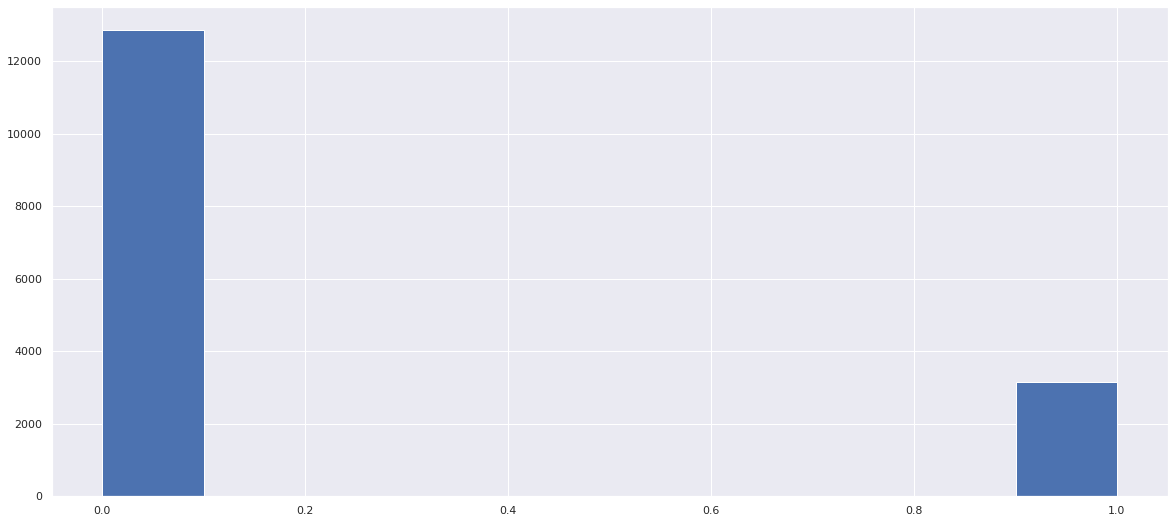

In [56]:
plt.hist(isplanetarr)

In [122]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA       #
from sklearn.pipeline import make_pipeline

pca = PCA(svd_solver='randomized', n_components=2, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [123]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(fluxlist, isplanetarr,
                                                random_state=42)

In [124]:
pca.fit(Xtrain,ytrain)

PCA(n_components=2, random_state=42, svd_solver='randomized', whiten=True)

In [125]:
pca.transform(Xtrain)

array([[ 0.74475579, -0.1849862 ],
       [-0.13956263,  0.03318039],
       [-0.16695046,  0.03208855],
       ...,
       [-0.16671307,  0.03203889],
       [-0.07404131,  0.12968034],
       [-0.09193118,  0.01484429]])

In [126]:
xtarr = pca.transform(Xtrain)

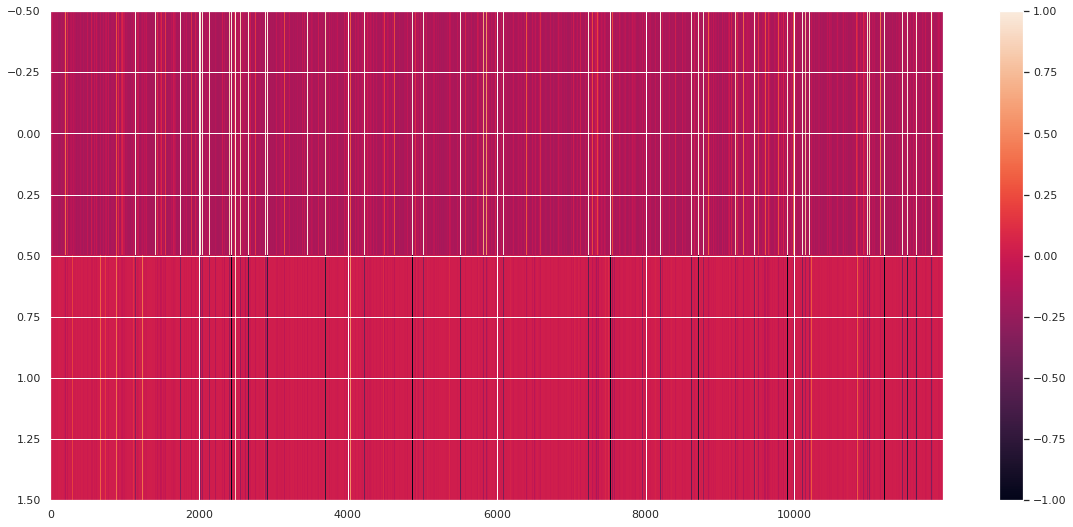

In [127]:
plt.imshow(xtarr.T,aspect='auto',vmin=-1, vmax=1, interpolation='nearest')
plt.colorbar()

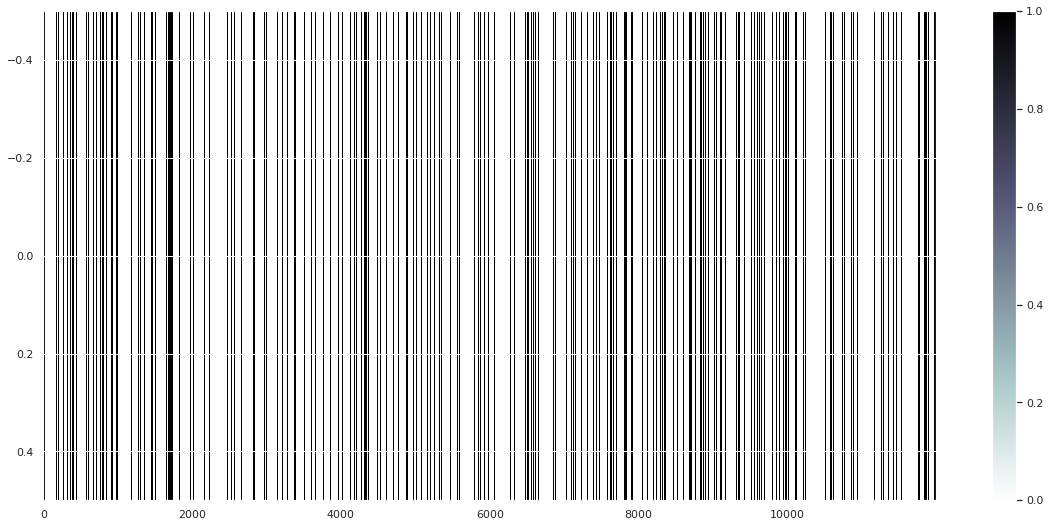

In [121]:
plt.imshow(ytrain.reshape(1,-1),aspect='auto',vmin=0, vmax=1, interpolation='nearest',cmap='bone_r')
plt.colorbar()

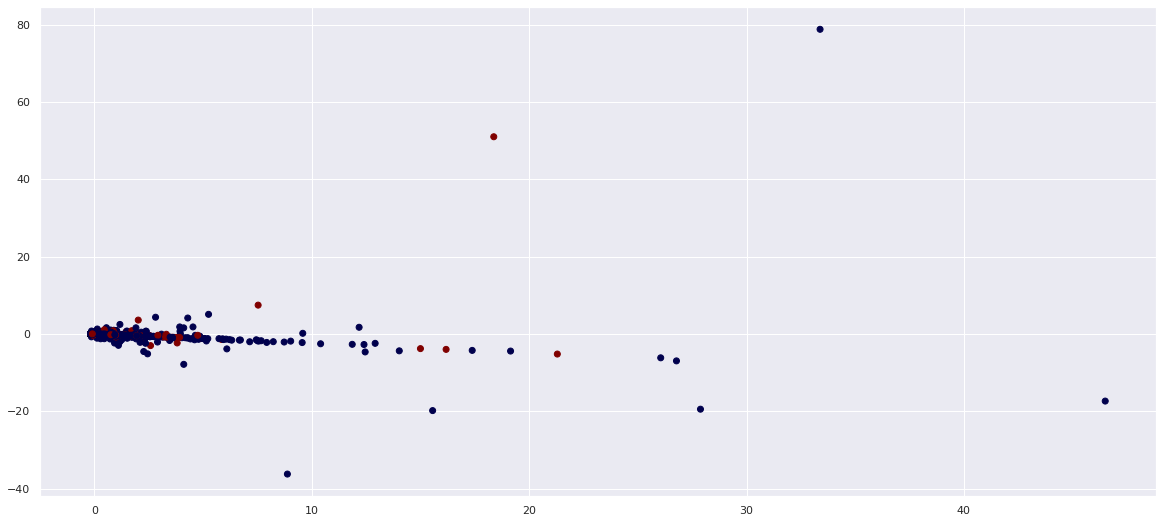

In [131]:
plt.scatter(xtarr[:,0],xtarr[:,1],c=ytrain,cmap='seismic')

In [72]:
param_grid = {'svc__C': 5,
              'svc__gamma': 0.0005}

%time model.fit(Xtrain, ytrain)#fit_params=param_grid)
#grid.fit(Xtrain, ytrain)
#print(grid.best_params_)

CPU times: user 2min 45s, sys: 1min 17s, total: 4min 2s
Wall time: 39 s


Pipeline(steps=[('pca',
                 PCA(n_components=150, random_state=42, svd_solver='randomized',
                     whiten=True)),
                ('svc', SVC(class_weight='balanced'))])

In [73]:
yfit=model.predict(Xtest)

In [74]:
yfit

array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)

(array([ 199.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3801.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

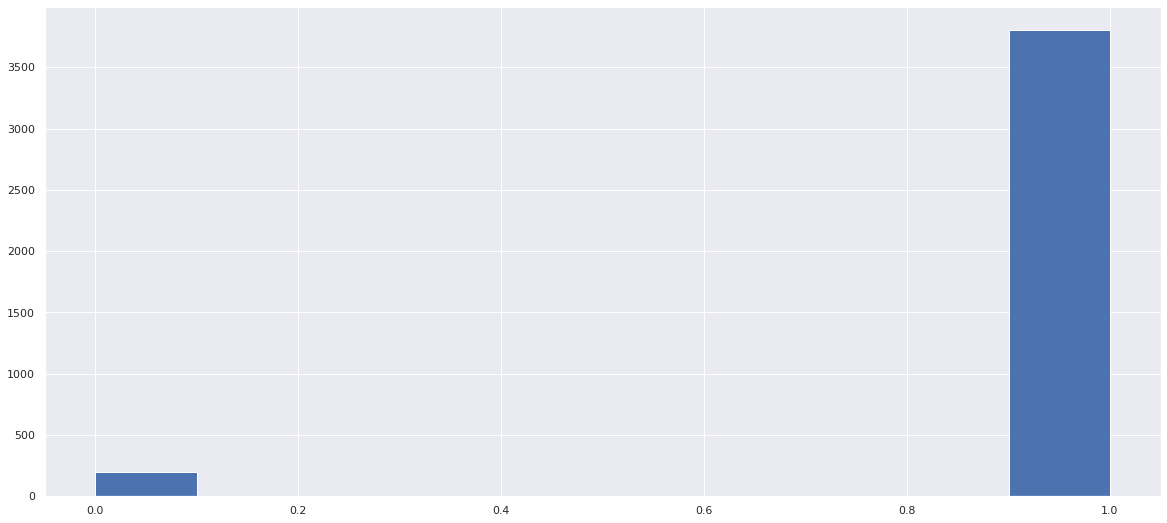

In [75]:
plt.hist(yfit)

(array([9597.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2403.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

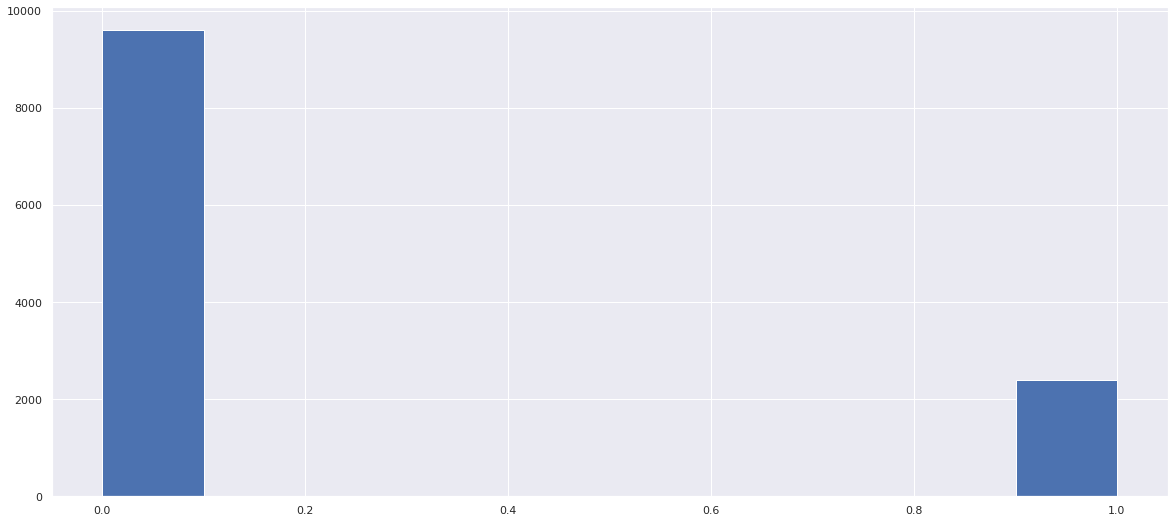

In [64]:
plt.hist(ytrain)

In [4]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

NameError: name 'plt' is not defined

lin regression = sum sqs of RESIDUALS
m*x_i + b    -   y_i
sum for i = total residual
want sum to be smallest over all m, b

cost function == what to minimise

change DF to have each col is a data point

imagine all x_i are LCs
y has to vals: True/False

Task: Work thru https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html

16000x289.. array